# Example from ROS Chapter 13

In [1]:
import numpyro 
import numpyro.distributions as dist 
from numpyro.infer import MCMC, NUTS, Predictive
import jax 
import jax.random as random 
import jax.numpy as jnp 

import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns; 
#sns.set_style("darkgrid"); 

plt.rcParams['figure.dpi'] = 100
# plt.rcParams.update({"grid.linewidth":0.5, "grid.alpha":0.5})
plt.style.use("dark_background")

In [2]:
def medstat(v):
    v = v.sort()
    med = v[len(v)//2]  # median
    mad = np.median(np.abs(v-med))  # median of absolute deviation
    mad_sd = 1.483 * mad
    return med, mad_sd

def print_abs_summary(d, keys=None):
    print('          Med  MAD_SD')
    for k, v in d.items():
        if (keys is None) or (k in keys):
            med, mad_sd = medstat(v)
            print(f'{k:7} {med:+5.3f}   {mad_sd:+5.3f}')

In [3]:
rngkey = random.PRNGKey(0)
rngkey, subkey = jax.random.split(rngkey)
rngkey

array([4146024105,  967050713], dtype=uint32)

Logistic (or sigmoid) function

$$
    \mathrm{logistic}(x) = \mathrm{sigmoid}(x) = \mathrm{expit}(x) = \frac{1}{1 + e^{-x}}
$$

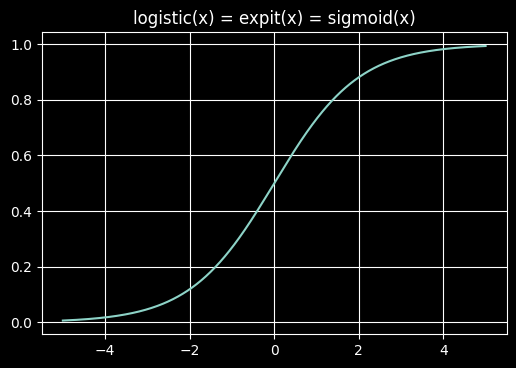

In [4]:
x = jnp.linspace(-5, 5, 1000)
p = jax.scipy.special.expit(x)

plt.plot(x, p);
plt.grid(); plt.title('logistic(x) = expit(x) = sigmoid(x)');

Inverse of expit is logit:

$$
    \mathrm{logit}(p) = \log\frac{p}{1-p} = x
$$

## American Election in 1992
- (American) National Election Study in 1992
- Bill Clinton vs J. Bush

In [6]:
import pandas as pd
url = 'https://raw.githubusercontent.com/avehtari/ROS-Examples/master/NES/data/nes.txt'
# df = pd.read_csv('ROS-Examples/NES/data/nes.txt', delimiter=' ')
df = pd.read_csv(url, delimiter=' ')


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34908 entries, 536 to 39986
Data columns (total 70 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   year             34908 non-null  int64  
 1   resid            34908 non-null  int64  
 2   weight1          34908 non-null  float64
 3   weight2          34908 non-null  float64
 4   weight3          34908 non-null  float64
 5   age              34908 non-null  int64  
 6   gender           34908 non-null  int64  
 7   race             34908 non-null  int64  
 8   educ1            34908 non-null  int64  
 9   urban            34381 non-null  float64
 10  region           34908 non-null  int64  
 11  income           34908 non-null  int64  
 12  occup1           31465 non-null  float64
 13  union            33531 non-null  float64
 14  religion         34713 non-null  float64
 15  educ2            34908 non-null  int64  
 16  educ3            34908 non-null  int64  
 17  martial_st

In [8]:
df

,year,resid,weight1,weight2,weight3,age,gender,race,educ1,urban,...,parent_party,white,year_new,income_new,age_new,vote.1,age_discrete,race_adj,dvote,rvote
536,1952,1,1.0000,1.0000,1.0000,25,2,1,2,2.0,...,2.0,1,1,1,-2.052455,1.0,1,1.0,0.0,1.0
537,1952,2,1.0000,1.0000,1.0000,33,2,1,1,2.0,...,0.0,1,1,1,-1.252455,1.0,2,1.0,1.0,0.0
538,1952,3,1.0000,1.0000,1.0000,26,2,1,2,2.0,...,-2.0,1,1,0,-1.952455,1.0,1,1.0,0.0,1.0
539,1952,4,1.0000,1.0000,1.0000,63,1,1,2,2.0,...,NaN,1,1,0,1.747545,1.0,3,1.0,0.0,1.0
540,1952,5,1.0000,1.0000,1.0000,66,2,1,2,2.0,...,-2.0,1,1,-2,2.047545,1.0,4,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39982,2000,1804,1.0454,1.0454,1.0454,51,2,1,2,NaN,...,NaN,1,24,0,0.547545,1.0,3,1.0,0.0,1.0
39983,2000,1805,1.0454,1.0454,1.0454,52,2,1,2,NaN,...,NaN,1,24,-1,0.647545,NaN,3,1.0,NaN,NaN
39984,2000,1808,2.0407,2.0407,2.0407,23,1,1,3,NaN,...,NaN,1,24,1,-2.252455,0.0,1,1.0,NaN,NaN
39985,2000,1809,0.3717,0.3717,0.3717,36,2,1,4,NaN,...,NaN,1,24,0,-0.952455,0.0,2,1.0,1.0,0.0


In [9]:
df.year.unique()  # what years are there?

array([1952, 1956, 1958, 1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974,
       1976, 1978, 1980, 1982, 1984, 1986, 1988, 1990, 1992, 1994, 1996,
       1998, 2000])

In [11]:
df.rvote

32093    1.0
32094    1.0
32095    NaN
32096    0.0
32097    1.0
        ... 
34035    NaN
34036    0.0
34037    1.0
34038    NaN
34039    NaN
Name: rvote, Length: 1724, dtype: float64

In [10]:
# we collect 1992 only, and [income, rvote] among the columns
df = df[ df.year == 1992 ][['income', 'rvote']]
df.head()

,income,rvote
32093,4,1.0
32094,2,1.0
32095,3,NaN
32096,1,0.0
32097,2,1.0


In [12]:
len(df)

1724

In [13]:
# remove NaN rows
df = df.dropna()
df.head()

,income,rvote
32093,4,1.0
32094,2,1.0
32096,1,0.0
32097,2,1.0
32098,3,0.0


In [14]:
len(df)

1356

In [17]:
df.income.unique()

array([4, 2, 1, 3, 5])

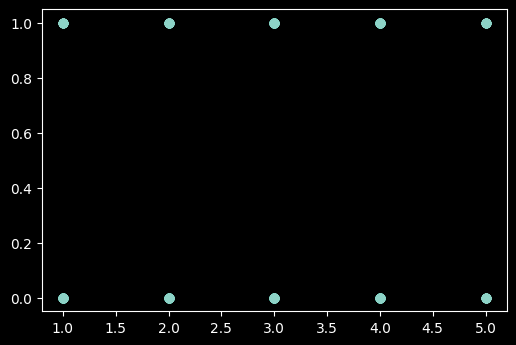

In [15]:
plt.scatter(df.income, df.rvote)

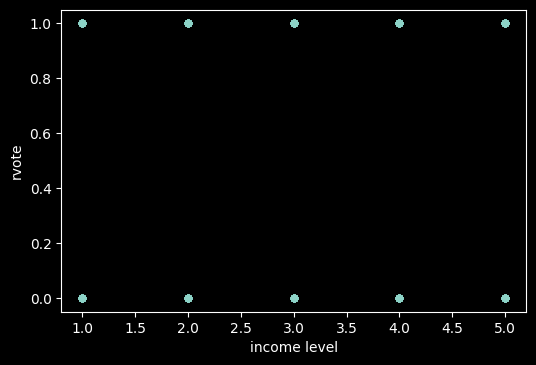

In [10]:
ax = df.plot(kind='scatter', x='income', y='rvote')
ax.set(xlabel='income level');

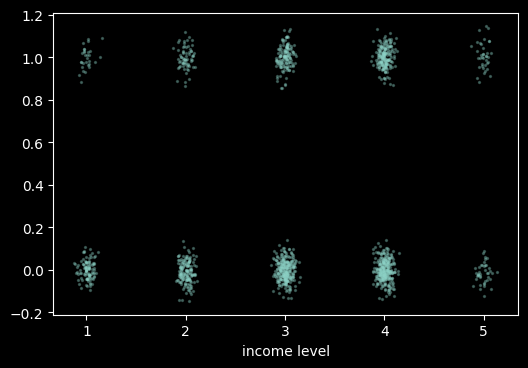

In [11]:
# do jitter to see data more vividly
ndata = len(df.income)
fig, ax = plt.subplots()
ax.scatter(df.income + np.random.randn(ndata,)*.1/2, 
           df.rvote+np.random.randn(ndata,)*.1/2, 
           s=2, alpha=.3)
ax.set(xlabel='income level');

In [18]:
def model_logistic(income, rvote=None):
    b0 = numpyro.sample('b0', dist.Normal(3, 3))  # distr. of income level
    b1 = numpyro.sample('b1', dist.Normal(0, 10)) # distr. of slope:  x = b0 + b1*income
    
    linear_pred = b0 +  b1 * income               # we have N income_i s
    theta = jax.scipy.special.expit(linear_pred)  # 

    with numpyro.plate('obs', size=len(income)):
        y = numpyro.sample('rvote', 
                          dist.Bernoulli(probs=theta),
                          obs=rvote)
#

In [19]:
kernel = NUTS(model_logistic)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=15000, num_chains=1)
#
#
mcmc.run(rngkey, df.income.values, df.rvote.values)
mcmc.print_summary(exclude_deterministic=False, prob=.8)

sample: 100%|██████████| 16000/16000 [00:16<00:00, 957.36it/s, 5 steps of size 2.03e-01. acc. prob=0.94]  



                mean       std    median     10.0%     90.0%     n_eff     r_hat
        b0     -1.44      0.18     -1.44     -1.67     -1.20   3263.31      1.00
        b1      0.26      0.05      0.26      0.19      0.33   3313.65      1.00

Number of divergences: 0


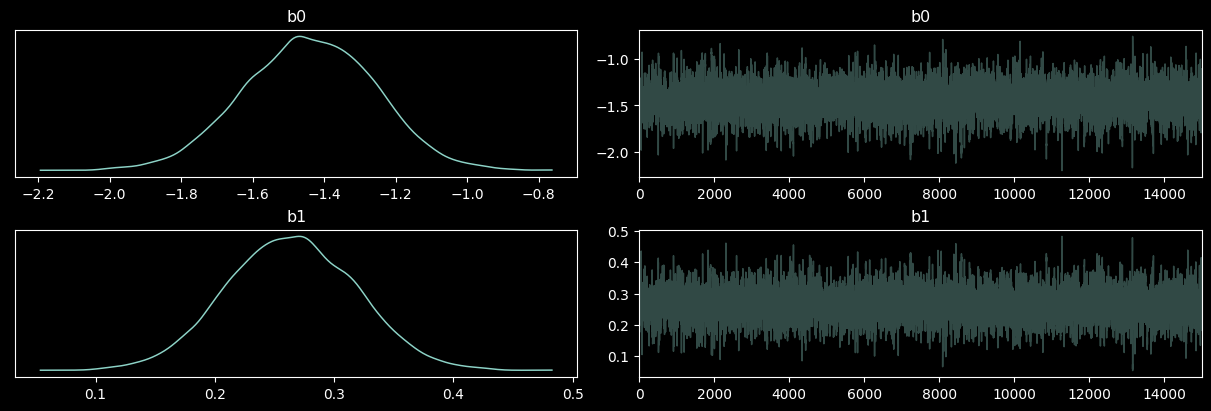

In [20]:
import arviz
azdata = arviz.from_numpyro(mcmc)
arviz.plot_trace(azdata);

In [ ]:
plt.scatter()

In [21]:
s = mcmc.get_samples()
print_abs_summary(s)    # median statistic

          Med  MAD_SD
b0      -1.442   +0.187
b1      +0.263   +0.056


In [22]:
s

{'b0': DeviceArray([-1.5748799, -1.504045 , -1.4574012, ..., -1.1076083,
              -1.255324 , -1.2587225], dtype=float32),
 'b1': DeviceArray([0.30259177, 0.25838768, 0.29229572, ..., 0.18187097,
              0.19098178, 0.21014436], dtype=float32)}

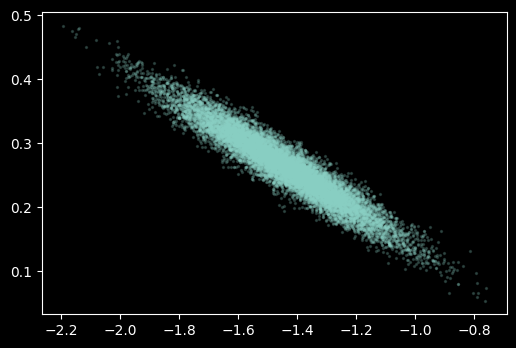

In [25]:
plt.scatter(s['b0'], s['b1'], s=2, alpha=.2)

In [16]:
# let's try median statistic to see what happens
import scipy 

b0med, b0sd = medstat(s['b0'])
b1med, b1sd = medstat(s['b1'])
income = np.array([1, 2, 3, 4, 5])
y = b0med + b1med * income
theta = scipy.special.expit(y)
theta

array([0.23534735, 0.2859501 , 0.34255883, 0.40403306, 0.46867487],
      dtype=float32)

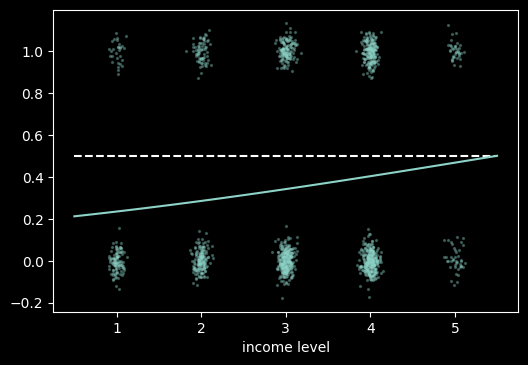

In [17]:
# do jitter to see data more vividly
ndata = len(df.income)
fig, ax = plt.subplots()
ax.scatter(df.income+np.random.randn(ndata,)*.1/2, 
           df.rvote+np.random.randn(ndata,)*.1/2, 
           s=2, alpha=.3)

xmin, xmax = .5, 5.5

x_income = np.linspace(xmin, xmax, 100)
theta = scipy.special.expit(b0med + b1med * x_income)
ax.plot(x_income, theta)

ax.hlines(y=.5, xmin=xmin, xmax=xmax, linestyles='--')
ax.set(xlabel='income level');

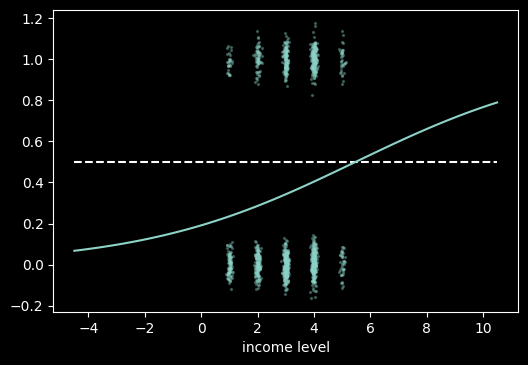

In [18]:
# do jitter to see data more vividly
ndata = len(df.income)
fig, ax = plt.subplots()
ax.scatter(df.income+np.random.randn(ndata,)*.1/2, 
           df.rvote+np.random.randn(ndata,)*.1/2, 
           s=2, alpha=.3)

xmin, xmax = .5-5, 5.5+5

x_income = np.linspace(xmin, xmax, 100)
theta = scipy.special.expit(b0med + b1med * x_income)
ax.plot(x_income, theta)

ax.hlines(y=.5, xmin=xmin, xmax=xmax, linestyles='--')
ax.set(xlabel='income level');

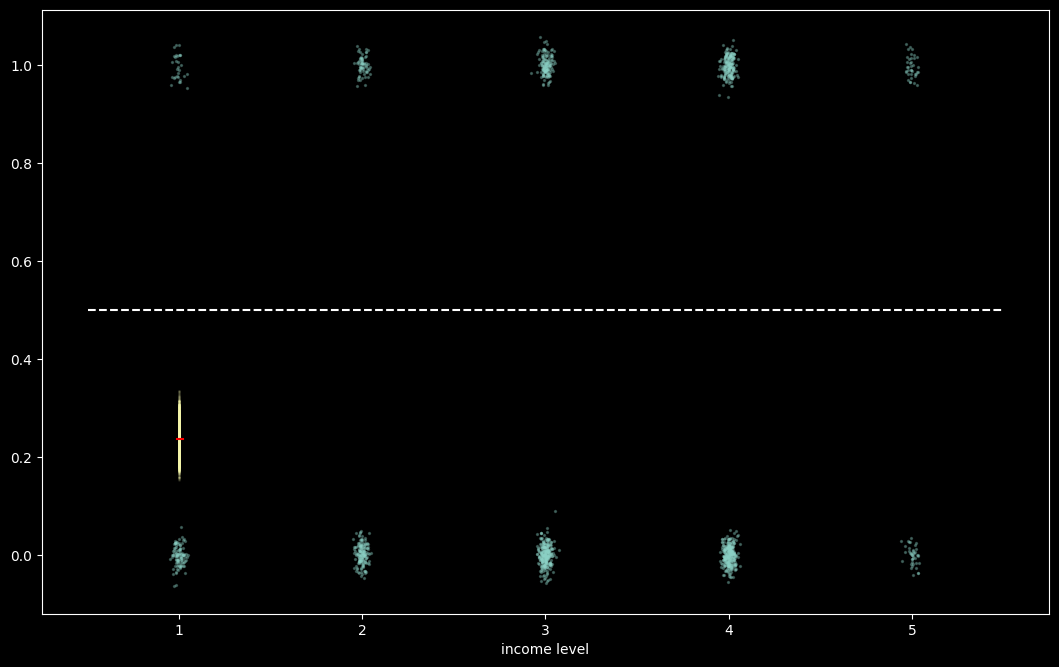

In [19]:
# do jitter to see data more vividly
ndata = len(df.income)
fig, ax = plt.subplots(figsize=(13,8))
ax.scatter(df.income+np.random.randn(ndata,)*.1/5, 
           df.rvote+np.random.randn(ndata,)*.1/5, 
           s=2, alpha=.3)

xmin, xmax = .5, 5.5

# let's see distr. of income level 1 for all samples of b0 & b1 
x_income = 1
theta = scipy.special.expit(s['b0'] + s['b1'] * x_income)
ax.scatter([x_income]*len(theta), theta, s=1, alpha=.1)
ax.plot([x_income-.01, x_income+.02], [theta.mean(), theta.mean()], c='r')

ax.hlines(y=.5, xmin=xmin, xmax=xmax, linestyles='--')
ax.set(xlabel='income level');

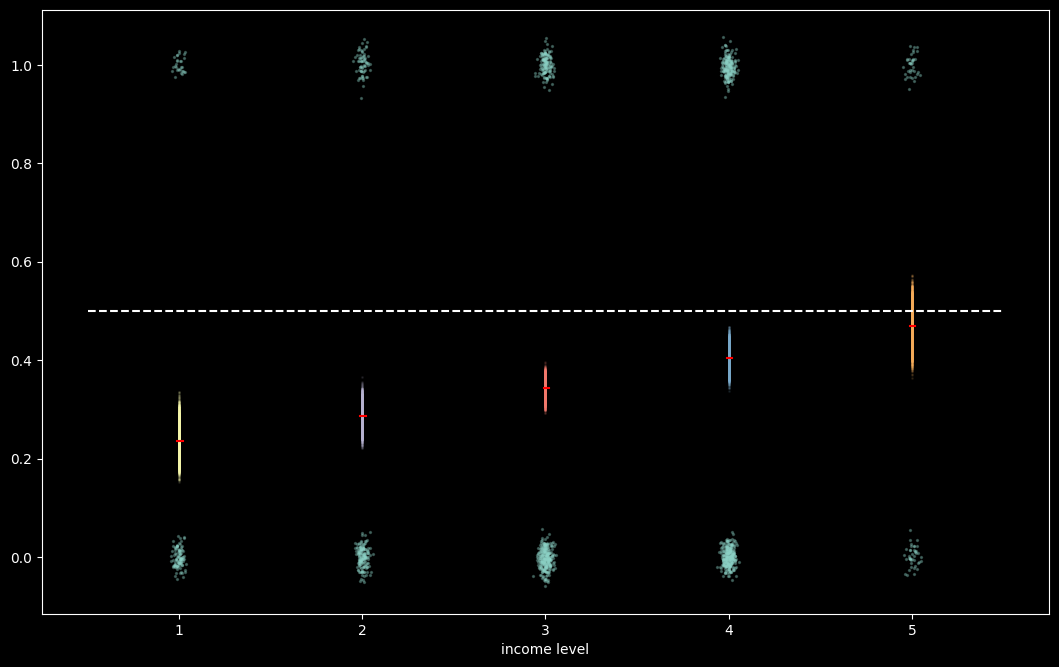

In [20]:
# do jitter to see data more vividly
ndata = len(df.income)
fig, ax = plt.subplots(figsize=(13,8))
ax.scatter(df.income+np.random.randn(ndata,)*.1/5, 
           df.rvote+np.random.randn(ndata,)*.1/5, 
           s=2, alpha=.3)

xmin, xmax = .5, 5.5

# let's see distr. of income level 1 for all samples of b0 & b1 
x_incomes = np.array([1,2,3,4,5])
for x_income in x_incomes:
    theta = scipy.special.expit(s['b0'] + s['b1'] * x_income)
    ax.scatter([x_income]*len(theta), theta, s=1, alpha=.1)
    ax.plot([x_income-.01, x_income+.02], [theta.mean(), theta.mean()], c='r')
#     ax.plot([x_income-.01, x_income+.02], [np.median(theta), np.median(theta)], c='b')

ax.hlines(y=.5, xmin=xmin, xmax=xmax, linestyles='--')
ax.set(xlabel='income level');

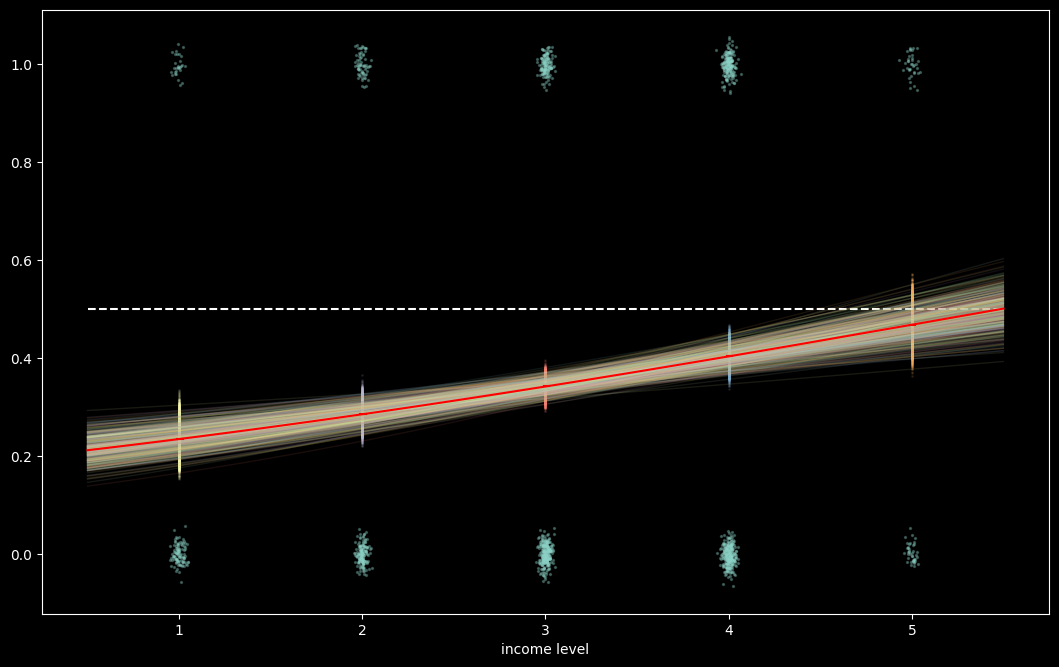

In [21]:
# do jitter to see data more vividly
ndata = len(df.income)
fig, ax = plt.subplots(figsize=(13,8))
ax.scatter(df.income+np.random.randn(ndata,)*.1/5, 
           df.rvote+np.random.randn(ndata,)*.1/5, 
           s=2, alpha=.3)

xmin, xmax = .5, 5.5
x_income = np.linspace(xmin, xmax, 100)
# sample curves
for i, (b0, b1) in enumerate(zip(s['b0'], s['b1'])):
    theta = scipy.special.expit(b0 + b1 * x_income)
    ax.plot(x_income, theta, lw=1, alpha=.1)
    if i > 512: break
# median curve
theta = scipy.special.expit(np.median(s['b0']) + np.median(s['b1']) * x_income)
ax.plot(x_income, theta, c='r')

# let's see distr. of income level 1 for all samples of b0 & b1 
x_incomes = np.array([1,2,3,4,5])
for x_income in x_incomes:
    theta = scipy.special.expit(s['b0'] + s['b1'] * x_income)
    ax.scatter([x_income]*len(theta), theta, s=1, alpha=.1)
    ax.plot([x_income-.01, x_income+.02], [theta.mean(), theta.mean()], c='r')

ax.hlines(y=.5, xmin=xmin, xmax=xmax, linestyles='--')
ax.set(xlabel='income level');

---

## Arsenic Wells in Bangladesh
- ROS page 232
- Switch the well or not.
- switch ~ distancd & arsenic 

In [22]:
df = pd.read_csv('ROS-Examples/Arsenic/data/wells.csv')
df

,switch,arsenic,dist,dist100,assoc,educ,educ4
0,1,2.36,16.826000,0.16826,0,0,0.00
1,1,0.71,47.321999,0.47322,0,0,0.00
2,0,2.07,20.966999,0.20967,0,10,2.50
3,1,1.15,21.486000,0.21486,0,12,3.00
4,1,1.10,40.874001,0.40874,1,14,3.50
...,...,...,...,...,...,...,...
3015,0,0.52,19.347000,0.19347,1,5,1.25
3016,0,1.08,21.386000,0.21386,1,3,0.75
3017,0,0.51,7.708000,0.07708,0,4,1.00
3018,0,0.64,22.841999,0.22842,0,3,0.75


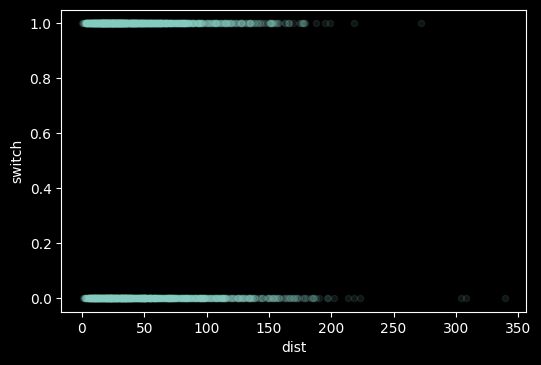

In [23]:
df.plot(kind='scatter', x='dist', y='switch', alpha=.1);

<AxesSubplot:ylabel='Frequency'>

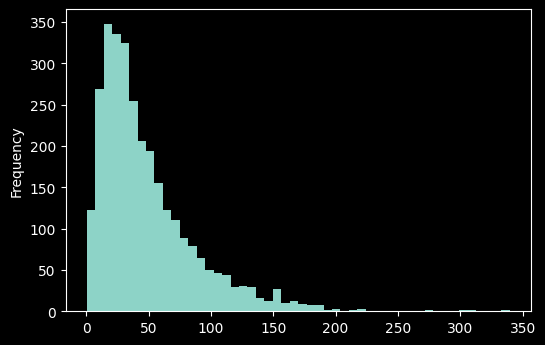

In [24]:
df['dist'].plot(kind='hist', bins=50)

## switch ~ dist

In [25]:
def model_well(switch, distance, arsenic=None):
    # switch = b0 + b1 * dist
    b0 = numpyro.sample('b0', dist.Normal(scale=100))   # approximate distr. of logit when distanc == 0
    b1 = numpyro.sample('b1', dist.Normal(0, 10))  # 대충. 엄밀함이 필요할수도.

    logit = numpyro.deterministic('logit', b0 + b1 * distance)
    theta = numpyro.deterministic('theta', jax.scipy.special.expit(logit)) # 

    with numpyro.plate('obs', size=len(switch)):
        y = numpyro.sample('switch', 
                          dist.Bernoulli(probs=theta),
                          obs=switch)
#

In [26]:
kernel = NUTS(model_well)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=15000, num_chains=1)
#
#
mcmc.run(rngkey, df.switch.values, df.dist.values)
mcmc.print_summary(exclude_deterministic=True, prob=.8)

sample: 100%|██████████| 16000/16000 [00:21<00:00, 758.59it/s, 7 steps of size 1.70e-01. acc. prob=0.94] 



                mean       std    median     10.0%     90.0%     n_eff     r_hat
        b0      0.61      0.06      0.61      0.53      0.69   3097.14      1.00
        b1     -0.01      0.00     -0.01     -0.01     -0.00   4195.58      1.00

Number of divergences: 0


In [27]:
s = mcmc.get_samples()
print(s.keys())
print_abs_summary(s, keys=['b0', 'b1'])    # median statistic

dict_keys(['b0', 'b1', 'logit', 'theta'])
          Med  MAD_SD
b0      +0.607   +0.060
b1      -0.006   +0.001


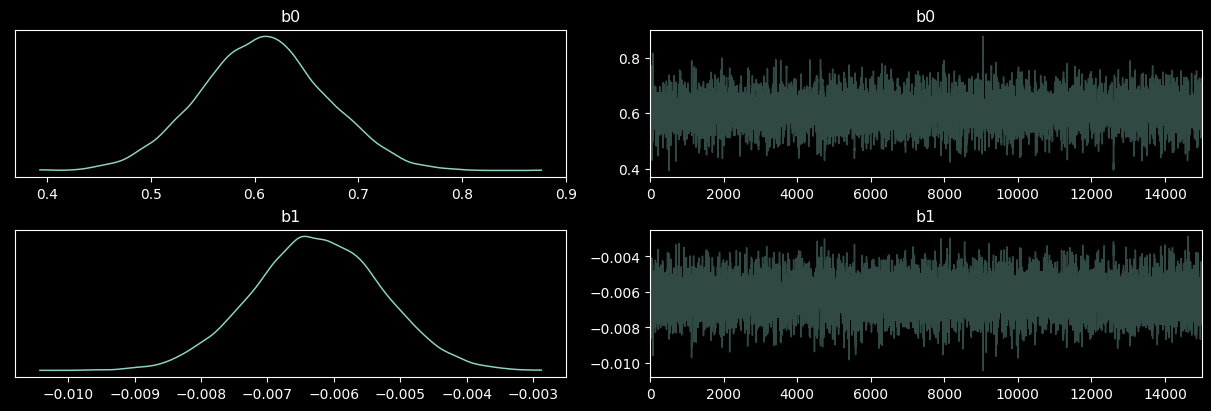

In [28]:
import arviz
azdata = arviz.from_numpyro(mcmc)
arviz.plot_trace(azdata, var_names=['b0', 'b1']);

''

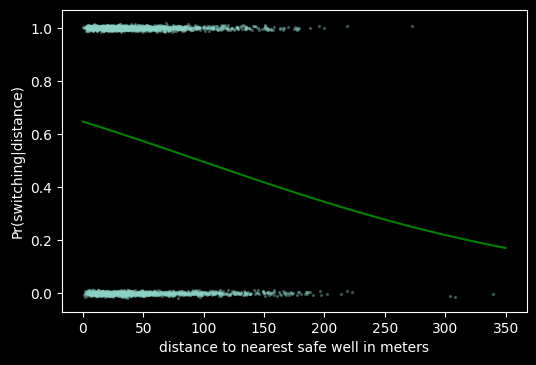

In [29]:
# do jitter to see data more vividly
ndata = len(df.switch)
fig, ax = plt.subplots()
ax.scatter(df.dist, df.switch+np.random.randn(len(df.switch))*.005, s=2, alpha=.3)
ax.set(xlabel='distance to nearest safe well in meters',
      ylabel='Pr(switching|distance)');

# Median Logistic Regression Curve
b0m, b0sd = medstat(s['b0'])
b1m, b1sd = medstat(s['b1'])
d = np.linspace(0, 350, 100)
y = scipy.special.expit( b0m + b1m * d)
ax.plot(d, y, c='g')
;

''

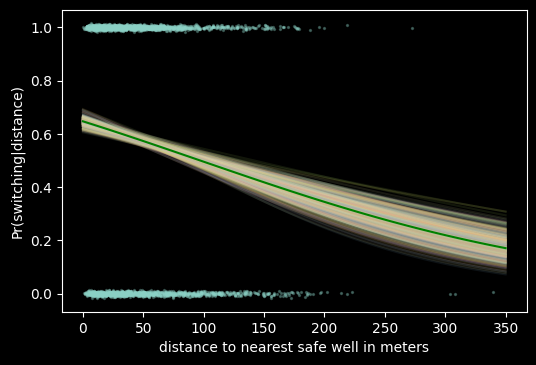

In [30]:
# do jitter to see data more vividly
ndata = len(df.switch)
fig, ax = plt.subplots()
ax.scatter(df.dist, df.switch+np.random.randn(len(df.switch))*.005, s=2, alpha=.3)
ax.set(xlabel='distance to nearest safe well in meters',
      ylabel='Pr(switching|distance)');

# uncertainty distribution along the median regression curve
for i, (b0, b1) in enumerate(zip(s['b0'], s['b1'])):
    d = np.linspace(0, 350, 100)
    y = scipy.special.expit( b0 + b1 * d)
    ax.plot(d, y, alpha=.1)    
    if i > 500: break
# median curve
b0m, b0sd = medstat(s['b0'])
b1m, b1sd = medstat(s['b1'])
d = np.linspace(0, 350, 100)
y = scipy.special.expit( b0m + b1m * d)
ax.plot(d, y, c='g')
;

## switch ~ arsenic

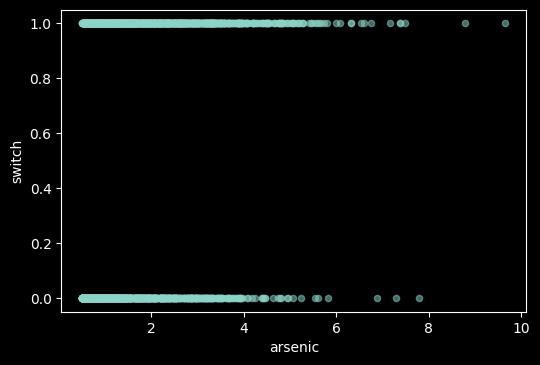

In [31]:
df.plot(x='arsenic', y='switch', kind='scatter', alpha=.5);

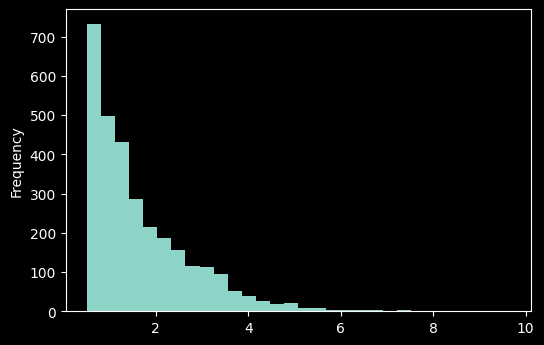

In [32]:
df['arsenic'].plot(kind='hist', bins=30);

In [33]:
(df.arsenic <= 0).sum()

0

In [34]:
def model_well_ars(switch, distance, arsenic):
    # switch = b0 + b1 * dist
    b0 = numpyro.sample('b0', dist.Normal(scale=100))   # approximately, distr. of logit when arsenic == 0
    b2 = numpyro.sample('b2', dist.Normal(0, 10))  # 대충. 엄밀함이 필요할수도.

    logit = numpyro.deterministic('logit', b0 + b2 * arsenic)
    theta = numpyro.deterministic('theta', jax.scipy.special.expit(logit)) # 

    with numpyro.plate('obs', size=len(switch)):
        y = numpyro.sample('switch', 
                          dist.Bernoulli(probs=theta),
                          obs=switch)
#

In [35]:
kernel = NUTS(model_well_ars)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=15000, num_chains=1)
#
#
mcmc.run(rngkey, df.switch.values, df.dist.values, df.arsenic.values)
mcmc.print_summary(exclude_deterministic=True, prob=.8)

sample: 100%|██████████| 16000/16000 [00:17<00:00, 913.75it/s, 3 steps of size 4.58e-01. acc. prob=0.92]  



                mean       std    median     10.0%     90.0%     n_eff     r_hat
        b0     -0.31      0.07     -0.31     -0.40     -0.22   3985.27      1.00
        b2      0.38      0.04      0.38      0.33      0.43   4046.84      1.00

Number of divergences: 0


In [36]:
s = mcmc.get_samples()
print(s.keys())
print_abs_summary(s, keys=['b0', 'b2'])    # median statistic

dict_keys(['b0', 'b2', 'logit', 'theta'])
          Med  MAD_SD
b0      -0.307   +0.071
b2      +0.380   +0.038


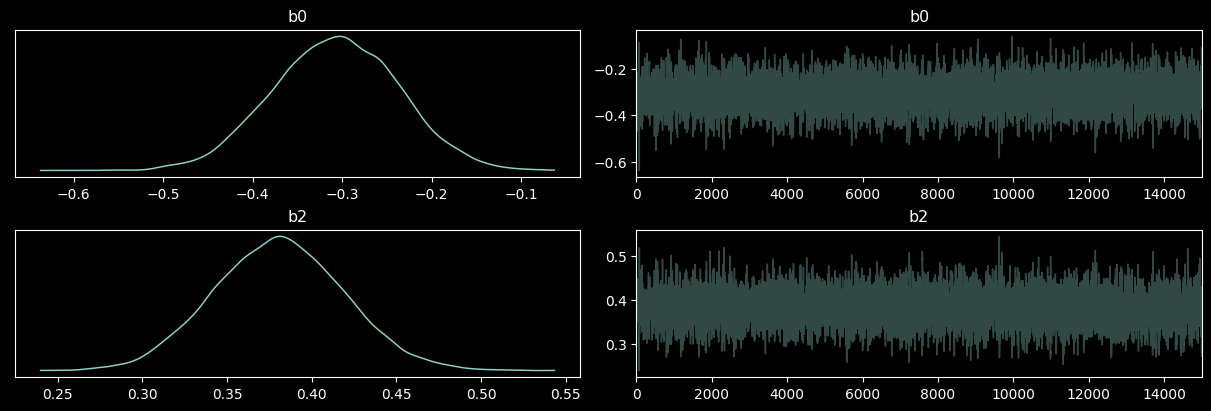

In [37]:
import arviz
azdata = arviz.from_numpyro(mcmc)
arviz.plot_trace(azdata, var_names=['b0', 'b2']);

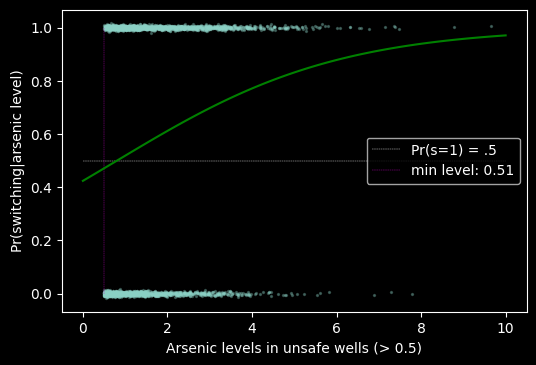

In [38]:
# do jitter to see data more vividly
ndata = len(df.switch)
fig, ax = plt.subplots()
ax.scatter(df.arsenic, df.switch+np.random.randn(len(df.switch))*.005, s=2, alpha=.3)
ax.set(xlabel='Arsenic levels in unsafe wells (> 0.5)',
      ylabel='Pr(switching|arsenic level)');

# Median Logistic Regression Curve
b0m, b0sd = medstat(s['b0'])
b2m, b2sd = medstat(s['b2'])
d = np.linspace(0, 10, 100)
y = scipy.special.expit( b0m + b2m * d)
ax.plot(d, y, c='g')
ax.hlines(y=.5, xmin=0, xmax=10, linestyles='--', linewidth=.3, label='Pr(s=1) = .5');
ax.vlines(x=df.arsenic.min(), ymin=0, ymax=1., linestyle='--', linewidth=.3, color='m', 
          label=f'min level: {df.arsenic.min():.2f}');
ax.legend();

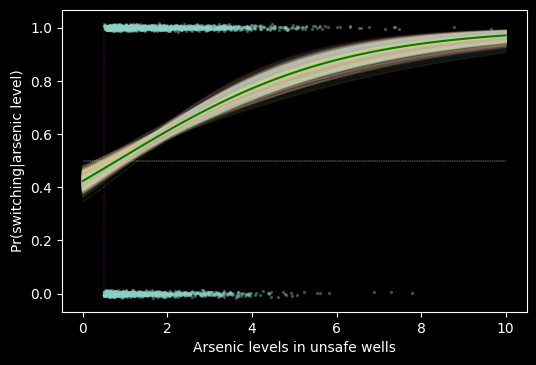

In [39]:
# do jitter to see data more vividly
ndata = len(df.switch)
fig, ax = plt.subplots()
ax.scatter(df.arsenic, df.switch+np.random.randn(len(df.switch))*.005, s=2, alpha=.3)
ax.set(xlabel='Arsenic levels in unsafe wells',
      ylabel='Pr(switching|arsenic level)');

# uncertainty distribution along the median regression curve
for i, (b0, b2) in enumerate(zip(s['b0'], s['b2'])):
    d = np.linspace(0, 10, 100)
    y = scipy.special.expit( b0 + b2 * d)
    ax.plot(d, y, alpha=.1)    
    if i > 1500: break
# median curve
b0m, b0sd = medstat(s['b0'])
b2m, b2sd = medstat(s['b2'])
d = np.linspace(0, 10, 100)
y = scipy.special.expit( b0m + b2m * d)
ax.plot(d, y, c='g')
ax.hlines(y=.5, xmin=0, xmax=10, linestyles='--', linewidth=.3);
ax.vlines(x=df.arsenic.min(), ymin=0, ymax=1., linestyle='--', linewidth=.3, color='m', 
          label=f'min level: {df.arsenic.min():.2f}');

---

## switch ~ dist + arsenic

In [40]:
def model_well(switch, distance, arsenic):
    # 
    b0 = numpyro.sample('b0', dist.Normal(scale=100))   # approximately, distr. of dist
    b1 = numpyro.sample('b1', dist.Normal(0, 10))  # 대충. 엄밀함이 필요할수도.
    b2 = numpyro.sample('b2', dist.Normal(0, 10))  # 대충. 엄밀함이 필요할수도.

    logit = numpyro.deterministic('logit', b0 + b1 * distance + b2 * arsenic)
    theta = numpyro.deterministic('theta', jax.scipy.special.expit(logit)) # 

    with numpyro.plate('obs', size=len(switch)):
        y = numpyro.sample('switch', 
                          dist.Bernoulli(probs=theta),
                          obs=switch)
#

In [41]:
kernel = NUTS(model_well)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=15000, num_chains=1)
#
mcmc.run(rngkey, df.switch.values, df.dist.values, df.arsenic.values)
mcmc.print_summary(exclude_deterministic=True, prob=.8)

sample: 100%|██████████| 16000/16000 [00:26<00:00, 605.93it/s, 7 steps of size 1.87e-01. acc. prob=0.92] 



                mean       std    median     10.0%     90.0%     n_eff     r_hat
        b0      0.00      0.08      0.00     -0.10      0.10   4070.51      1.00
        b1     -0.01      0.00     -0.01     -0.01     -0.01  10011.72      1.00
        b2      0.46      0.04      0.46      0.41      0.51   3957.00      1.00

Number of divergences: 0


In [42]:
s = mcmc.get_samples()
print(s.keys())
print_abs_summary(s, keys=['b0', 'b1', 'b2'])    # median statistic

dict_keys(['b0', 'b1', 'b2', 'logit', 'theta'])
          Med  MAD_SD
b0      +0.004   +0.080
b1      -0.009   +0.001
b2      +0.461   +0.041


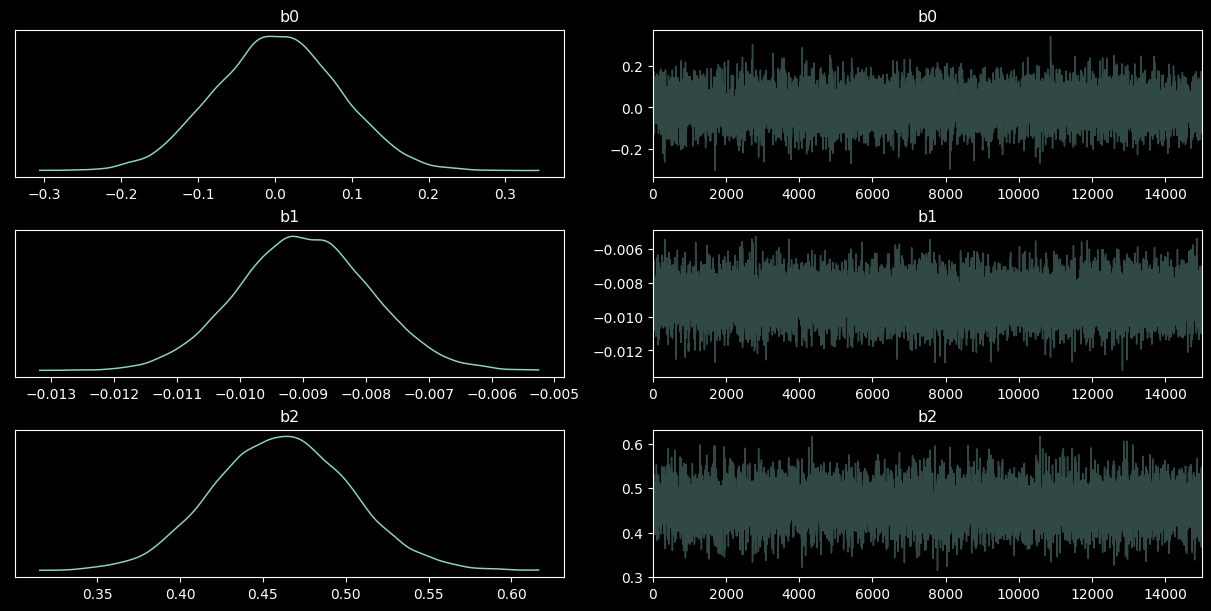

In [43]:
import arviz
azdata = arviz.from_numpyro(mcmc)
arviz.plot_trace(azdata, var_names=['b0', 'b1', 'b2']);

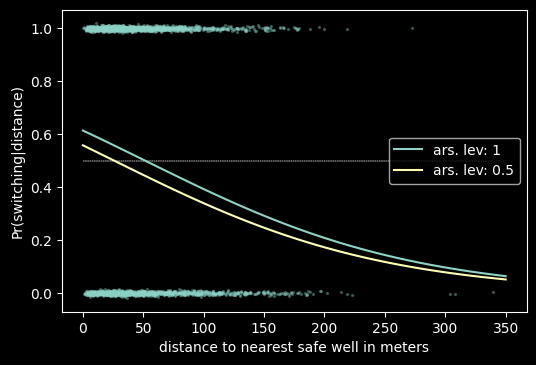

In [44]:
# do jitter to see data more vividly
ndata = len(df.switch)
fig, ax = plt.subplots()
ax.scatter(df.dist, df.switch+np.random.randn(len(df.switch))*.005, s=2, alpha=.3)
ax.set(xlabel='distance to nearest safe well in meters',
      ylabel='Pr(switching|distance)');

# Median Logistic Regression Curve
b0m, b0sd = medstat(s['b0'])
b1m, b1sd = medstat(s['b1'])
b2m, b2sd = medstat(s['b2'])
d = np.linspace(0, 350, 100)
arsenal_level = [1, 0.5]
for a in arsenal_level:
    y = scipy.special.expit( b0m + b1m * d + b2m * a)
    ax.plot(d, y, label=f'ars. lev: {a}')
    ax.hlines(y=.5, xmin=0, xmax=350, linestyles='--', linewidth=.3);
ax.legend();

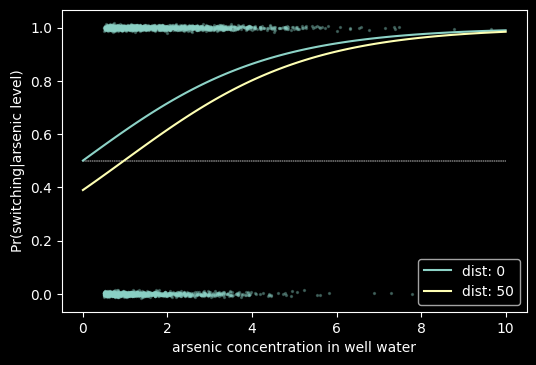

In [45]:
# do jitter to see data more vividly
ndata = len(df.switch)
fig, ax = plt.subplots()
ax.scatter(df.arsenic, df.switch+np.random.randn(len(df.switch))*.005, s=2, alpha=.3)
ax.set(xlabel='arsenic concentration in well water',
      ylabel='Pr(switching|arsenic level)');

# Median Logistic Regression Curve
b0m, b0sd = medstat(s['b0'])
b1m, b1sd = medstat(s['b1'])
b2m, b2sd = medstat(s['b2'])
a = np.linspace(0, 10, 100)
dist_level = [0, 50]
for d in dist_level:
    y = scipy.special.expit( b0m + b1m * d + b2m * a)
    ax.plot(a, y, label=f'dist: {d}')
    ax.hlines(y=.5, xmin=0, xmax=10, linestyles='--', linewidth=.3);
ax.legend();

---

## switch ~ dist100 + arsenic

- dist100 = dist / 100

In [46]:
def model_100(switch, distance, arsenic):
    #  
    b0 = numpyro.sample('b0', dist.Normal(scale=1)) # scale!
    b1 = numpyro.sample('b1', dist.Normal(0, 10))  # 
    b2 = numpyro.sample('b2', dist.Normal(0, 10))  # 

    logit = numpyro.deterministic('logit', b0 + b1 * distance + b2 * arsenic)
    theta = numpyro.deterministic('theta', jax.scipy.special.expit(logit)) # 

    with numpyro.plate('obs', size=len(switch)):
        y = numpyro.sample('switch', 
                          dist.Bernoulli(probs=theta),
                          obs=switch)
#

In [47]:
kernel = NUTS(model_100)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=15001, num_chains=1)
#
mcmc.run(rngkey, df.switch.values, df.dist100.values, df.arsenic.values)
mcmc.print_summary(exclude_deterministic=True, prob=.8)

sample: 100%|██████████| 16001/16001 [00:21<00:00, 735.34it/s, 15 steps of size 3.91e-01. acc. prob=0.91]



                mean       std    median     10.0%     90.0%     n_eff     r_hat
        b0      0.00      0.08      0.00     -0.09      0.11   6413.90      1.00
        b1     -0.90      0.10     -0.90     -1.04     -0.77   8072.12      1.00
        b2      0.46      0.04      0.46      0.41      0.51   6570.52      1.00

Number of divergences: 0


In [48]:
np.median(mcmc.get_samples()['b0'])

0.0037474087

In [49]:
a = s['b0']
a.sort()[a.size//2]

DeviceArray(0.00371034, dtype=float32)

In [50]:
s = mcmc.get_samples()
print(s.keys())
print_abs_summary(s, keys=['b0', 'b1', 'b2'])    # median statistic

dict_keys(['b0', 'b1', 'b2', 'logit', 'theta'])
          Med  MAD_SD
b0      +0.004   +0.081
b1      -0.899   +0.105
b2      +0.461   +0.041


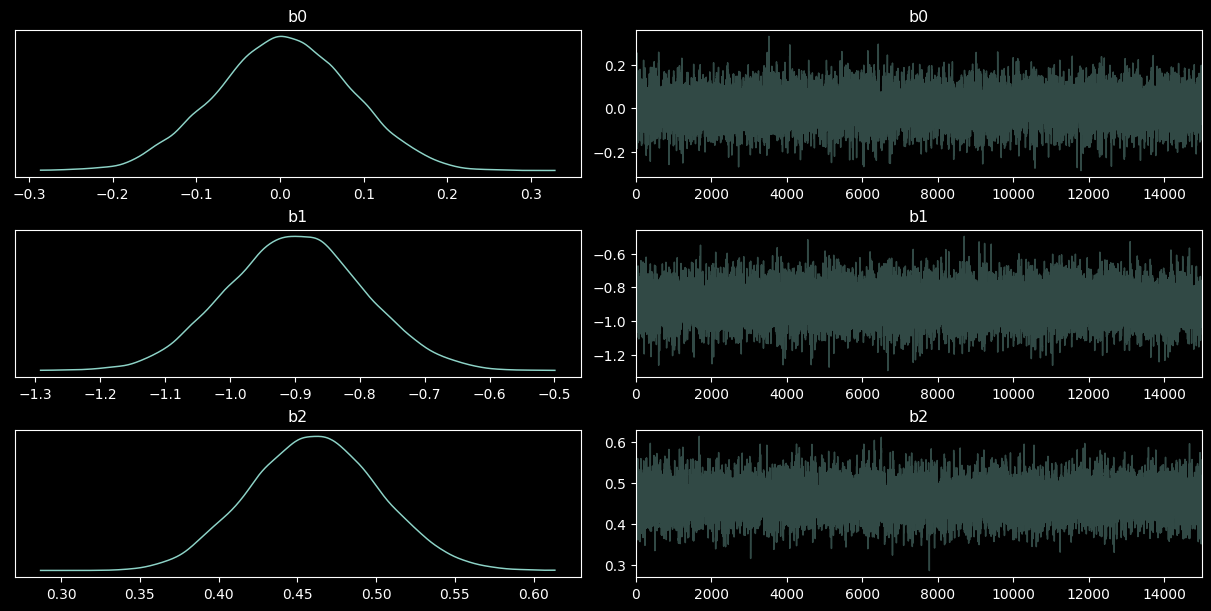

In [51]:
import arviz
azdata = arviz.from_numpyro(mcmc)
arviz.plot_trace(azdata, var_names=['b0', 'b1', 'b2']);

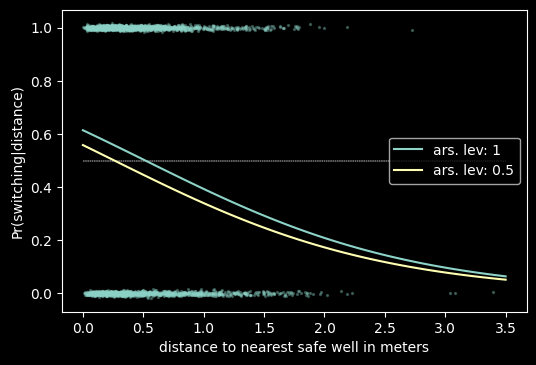

In [52]:
# do jitter to see data more vividly
ndata = len(df.switch)
fig, ax = plt.subplots()
ax.scatter(df.dist100, df.switch+np.random.randn(len(df.switch))*.005, s=2, alpha=.3)
ax.set(xlabel='distance to nearest safe well in meters',
      ylabel='Pr(switching|distance)');

# Median Logistic Regression Curve
b0m, b0sd = medstat(s['b0'])
b1m, b1sd = medstat(s['b1'])
b2m, b2sd = medstat(s['b2'])
d = np.linspace(0, 350/100, 100)
arsenal_level = [1, 0.5]
for a in arsenal_level:
    y = scipy.special.expit( b0m + b1m * d + b2m * a)
    ax.plot(d, y, label=f'ars. lev: {a}')
    ax.hlines(y=.5, xmin=0, xmax=350/100, linestyles='--', linewidth=.3);
ax.legend();

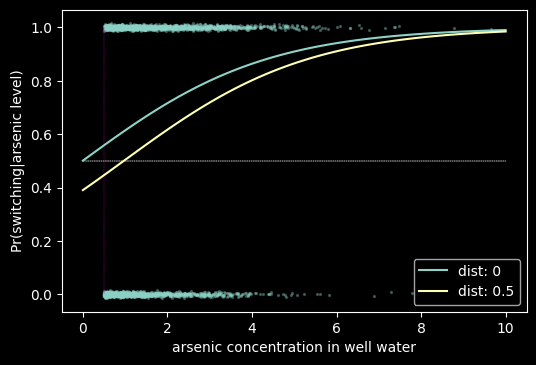

In [53]:
# do jitter to see data more vividly
ndata = len(df.switch)
fig, ax = plt.subplots()
ax.scatter(df.arsenic, df.switch+np.random.randn(len(df.switch))*.005, s=2, alpha=.3)
ax.set(xlabel='arsenic concentration in well water',
      ylabel='Pr(switching|arsenic level)');

# Median Logistic Regression Curve
b0m, b0sd = medstat(s['b0'])
b1m, b1sd = medstat(s['b1'])
b2m, b2sd = medstat(s['b2'])
a = np.linspace(0, 10, 100)
dist_level = [0, 50/100]
for d in dist_level:
    y = scipy.special.expit( b0m + b1m * d + b2m * a)
    ax.plot(a, y, label=f'dist: {d}')
    ax.hlines(y=.5, xmin=0, xmax=10, linestyles='--', linewidth=.3);
ax.legend();
ax.vlines(x=df.arsenic.min(), ymin=0, ymax=1., linestyle='--', linewidth=.3, color='m', 
          label=f'min level: {df.arsenic.min():.2f}');

---

End.

In [56]:
!jupyter nbconvert Ch.6.Bernoulli_Logistic_Examples.ipynb --to webpdf --HTMLExporter.theme=dark --allow-chromium-download

[NbConvertApp] Converting notebook Ch.6.Bernoulli_Logistic_Examples.ipynb to html
[NbConvertApp] Writing 2150404 bytes to Ch.6.Bernoulli_Logistic_Examples.html


In [61]:
!jupyter nbconvert Ch.6.Bernoulli_Logistic_Examples.ipynb --to html --HTMLExporter.theme=dark --allow-chromium-download

[NbConvertApp] Converting notebook Ch.6.Bernoulli_Logistic_Examples.ipynb to html
[NbConvertApp] Writing 2180631 bytes to Ch.6.Bernoulli_Logistic_Examples.html
